# Practical 1: RNN for Sentiment Analysis

### Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Input Pipeline Setup
The IMDB movie review dataset is a binary classification dataset—all reviews have either positive or negative sentiment.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this will return a dataset (text, label pairs)

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create a collection of these (text, label) pairs

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'The van trotta movie rosenstrasse is the best movie i have seen in years. i am actually not really interested in films with historical background but with this she won my interest for that time!!<br /><br />the only annoying thing about the movie have been the scenes in new york, and the impression i had of "trying to be as American as possible" ... which i think has absolutely failed.<br /><br />the scenes in the back really got to my heart. the German actress katja riemann completely deserved her award. she is one of the most impressing actress i have ever seen. in future i will watch more of her movies. great luck for me that i am a native German speaking =) and only for a year in the us, so as soon as i am back i\'ll buy some riemann dvds.<br /><br />so to all out there who have not seen this movie yet: WATCH IT!!! i think it would be too long to describe what it is all about yet, especially all the flash backs and switches of times are hard to explain, but simply watcxh

### Create Text Encoder
The raw text loaded by tfds needs to be processed before it can be used in the model. The easiest way to process text for training is using a TextVectorization layer. This layer has many capabilities, but in this tutorial it uses the default behavior. Create the layer, and pass the dataset text to the layer's .adapt method:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer vocabulary. The first 20 tokens can be viewed with the following code. After padding and unknown tokens, they are sorted by frequency

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode the text into an index. The index tensor is padded 0 to the longest sequence in the batch (unless you set a fixed output_sequence_length)

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 2,  1,  1, ...,  0,  0,  0],
       [11, 20,  7, ...,  0,  0,  0],
       [10, 67,  2, ...,  0,  0,  0]])

With default settings, the process cannot be completely reversed. There are two main reasons for that:

- The default value for the preprocessing.TextVectorization standardization argument is "lower_and_strip_punctuation".

- Limited vocabulary size and lack of character-based fallback resulted in some unknown tokens.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The van trotta movie rosenstrasse is the best movie i have seen in years. i am actually not really interested in films with historical background but with this she won my interest for that time!!<br /><br />the only annoying thing about the movie have been the scenes in new york, and the impression i had of "trying to be as American as possible" ... which i think has absolutely failed.<br /><br />the scenes in the back really got to my heart. the German actress katja riemann completely deserved her award. she is one of the most impressing actress i have ever seen. in future i will watch more of her movies. great luck for me that i am a native German speaking =) and only for a year in the us, so as soon as i am back i\'ll buy some riemann dvds.<br /><br />so to all out there who have not seen this movie yet: WATCH IT!!! i think it would be too long to describe what it is all about yet, especially all the flash backs and switches of times are hard to explain, but simply watc

### Create Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To ensure that it works as expected, evaluate a sentence twice. First, one sentence so there is no padding to hide

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.02465501]


Now, evaluate again in batches with longer sentences. The results should be the same

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 64ms/step
[-0.02465501]


Compile the Keras model to configure the training process

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 107ms/step - loss: 0.6627 - accuracy: 0.5424 - val_loss: 0.5332 - val_accuracy: 0.7469
Epoch 2/10
391/391 [==============================] - 24s 62ms/step - loss: 0.4166 - accuracy: 0.8096 - val_loss: 0.3645 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3415 - accuracy: 0.8512 - val_loss: 0.3445 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3243 - accuracy: 0.8596 - val_loss: 0.3348 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3123 - accuracy: 0.8656 - val_loss: 0.3275 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3077 - accuracy: 0.8674 - val_loss: 0.3282 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3051 - accuracy: 0.8691 - val_loss: 0.3221 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3204 - accuracy: 0.8606
Test Loss: 0.32038626074790955
Test Accuracy: 0.8605599999427795


(0.0, 0.6808572515845299)

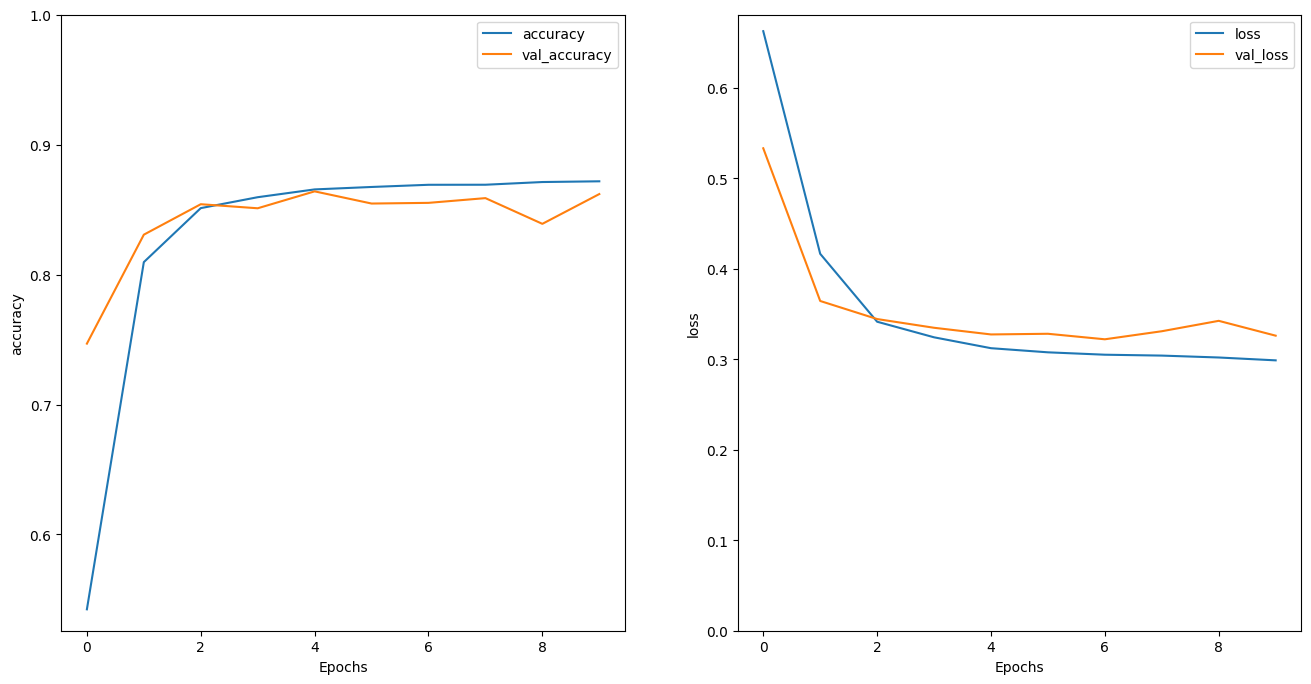

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on new sentences:

If the prediction is >= 0.0 it is positive, otherwise it is negative

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.53240705]


### Stack Two or More LSTM Layers

The interesting thing about using RNN with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to another RNN layer, like this

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 153ms/step - loss: 0.6388 - accuracy: 0.5636 - val_loss: 0.4563 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.4011 - accuracy: 0.8231 - val_loss: 0.3598 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3436 - accuracy: 0.8512 - val_loss: 0.3419 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3198 - accuracy: 0.8637 - val_loss: 0.3266 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3109 - accuracy: 0.8653 - val_loss: 0.3254 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3055 - accuracy: 0.8686 - val_loss: 0.3239 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3020 - accuracy: 0.8726 - val_loss: 0.3253 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3230 - accuracy: 0.8623
Test Loss: 0.32302430272102356
Test Accuracy: 0.862280011177063


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6027161]]


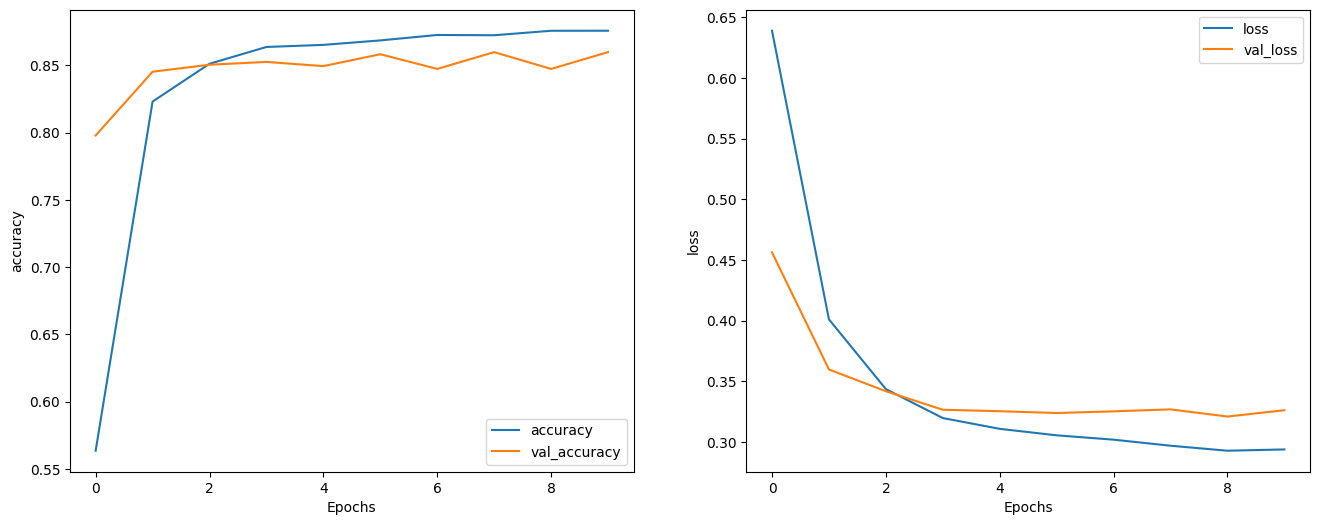

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')